<h1> Binary Wine Quality Classification with Physicochemical Data </h1>

<b> INTRODUCTION </b>

Wine is an alcoholic drink, typically made from fermented grapes. The wine industry has begun to invest in new technologies for increasing the supply and aiding the selling process of wine (Cortez et al., 2009). Quality, as it relates to wine, can often be viewed as intrinsic or extrinsic, meaning the physicochemical characteristics or characteristics such as price and prestige (Jackson, 2017). Our classification will focus on the physicochemical properties because as these components and sensory variables change, there is often also a difference in the quality of the raw materials and process. Understanding wine quality is something that agriculturists and researchers in the field are constantly striving to improve. By pinning down the relevant physicochemical characteristics involved in determining quality, we can tackle the difficult task of determining what constitutes wine quality. In this report, we aim to determine if, based on physicochemical data, we can categorize whether the quality of wine will be above or below average based on consumer preferences. 

The dataset we are using is extracted from a paper by Cortez et al. (2017), titled “Modeling wine preferences by data mining from physicochemical properties”. The purpose of the study was to utilize a data mining approach to assist in the quality evaluation of wine based on human preferences. The dataset consisted of red and white vinho verde wine from the north of Portugal. Each row indicates the test for one type of wine including physicochemical variables (e.g. fixed acidity, volatile acidity, residual sugar) and an index indicating the condition (quality). In order to assess and predict the quality of wine, it is essential to find the relationship between these physicochemical statistics and wine quality. We will be doing this through a process called binary classification. Binary classification takes charge of “classifying data items into two predertermined classes” (Attar et al., 2011; Dina & Manivannan, 2021; Galbusera et al., 2019). In the project, we kept track of the physicochemical statistics from each observation of wine. In doing so we were able to employ binary classification as a way to put the new observation into the two predetermined classes, “good” and “bad” quality, and gain a broader understanding of wine preferences.


<b> METHOD </b>

To answer our question, we collect data then identify promising predictor variables through their correlations to the binary target variable. We then implement the forward selection feature selection process to find combination optimized for accuracy. Using the found optimal combination of variables, we find the optimal K-value for the KNN model. We finally make predictions on the test set and present our confusion matrix and accuracy. 

We start by loading necessary libraries and set the maximum amount of displayable rows for tables to 12.

In [ ]:
# Loading libraries
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 12)

We then copy the URLs into the objects ww_url and rw_url and then use these objects as arguments for the read_delim() function. We set the delimiter to the delimiter used in the file, a semi-colon, and set column names to true so this data frame inherits the column names of the file. We then use the colnames() function to convert all column names to the tidy-format that has no spaces. The result are variable names where spaces are represented by periods.

We abbreviate "red wine" as "rw" and "white wine" as "ww" for brevity and convenience hereinafter.

In [35]:
# Loading the data
ww_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
rw_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
ww <- read_delim(ww_url, delim = ";", col_names = TRUE)
rw <- read_delim(rw_url, delim = ";", col_names = TRUE)

colnames(ww) <- make.names(colnames(ww))
colnames(rw) <- make.names(colnames(rw))

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.8,0.620,0.08,1.9,0.068,28,38,0.99651,3.42,0.82,9.5,6
6.2,0.600,0.08,2.0,0.090,32,44,0.99490,3.45,0.58,10.5,5


Below we summarize each dataset to gain preliminary insight into the datasets. We use the summary() function that returns the minimum, 1st quartile, median, mean, 3rd quartile, and max values of each variable, for which there are 12. We also use quotation marks around strings in the text to seperate the data to make the output more legible.

In [90]:
# Red wine summary statistics
"red wine statistics"
summary(rw)

# white wine summary statistics
"white wine statistics"
summary(ww)

[1] "red wine statistics"

 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

[1] "white wine statistics"

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 5.200  
 Mean   : 6.855   Mean   :0.2782   Mean   :0.3342   Mean   : 6.391  
 3rd Qu.: 7.300   3rd Qu.:0.3200   3rd Qu.:0.3900   3rd Qu.: 9.900  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00      1st Qu.:108.0        1st Qu.:0.9917  
 Median :0.04300   Median : 34.00      Median :134.0        Median :0.9937  
 Mean   :0.04577   Mean   : 35.31      Mean   :138.4        Mean   :0.9940  
 3rd Qu.:0.05000   3rd Qu.: 46.00      3rd Qu.:167.0        3rd Qu.:0.9961  
 Max.   :0.34600   Max.   :289.00      Max.   :440.0   

Below we use a simple if_else() function to create a new variable named binary.quality. This variable, binary.quality, is binary conversion of the multi-categorial variable, quality, where 0 represents "bad" or below average, and 1 represents "good" or above average using. We purposefully do this to achieve better class balance as quality is approximately normally distributed between 5 and 6.

We split the classes based on the average quality score we calculate for each wine data set using the mean() function. Within the parameters of the function, we use the "$" to specify the column we take the average from.

In [91]:
options(repr.plot.height = 15, repr.plot.width = 15)

# Calculating the wine quality averages
rw_avg <- mean(rw$quality)
ww_avg <- mean(ww$quality)

# Converting quality to binary scores as factors
rw_bin <- rw %>%
    mutate(binary.quality = as_factor(if_else(quality < rw_avg, 0,1)))

ww_bin <- ww %>%
    mutate(binary.quality = as_factor(if_else(quality < ww_avg, 0,1)))

# Converting quality to binary scores without factorizing
rw_bin_non_fct <- rw %>%
    mutate(binary.quality = if_else(quality < rw_avg, 0,1))

ww_bin_non_fct <- ww %>%
    mutate(binary.quality = if_else(quality < ww_avg, 0,1))

We use ggpairs() to create a summary of the variables and their respective distributions. We also use cor() to calcualate the correlations between each predictor variable and the response variable (binary.quality).

We convert the resulting cor() matrix to a data frame as we cannot use functions like select() and arrange() on a vector. We also arrange the resulting data frame by descending absolute order and remove the top two correlations as they are between binary.quality and binary.quality then quality. 

This information is presented below to better inform which dataset to use given its prospects for a fruitful data analysis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



,binary.quality
,<dbl>
alcohol,0.434751205
volatile.acidity,-0.321440854
total.sulfur.dioxide,-0.231962976
sulphates,0.218071663
citric.acid,0.159129408
density,-0.159109969
chlorides,-0.109493996
fixed.acidity,0.095093490
free.sulfur.dioxide,-0.061756744


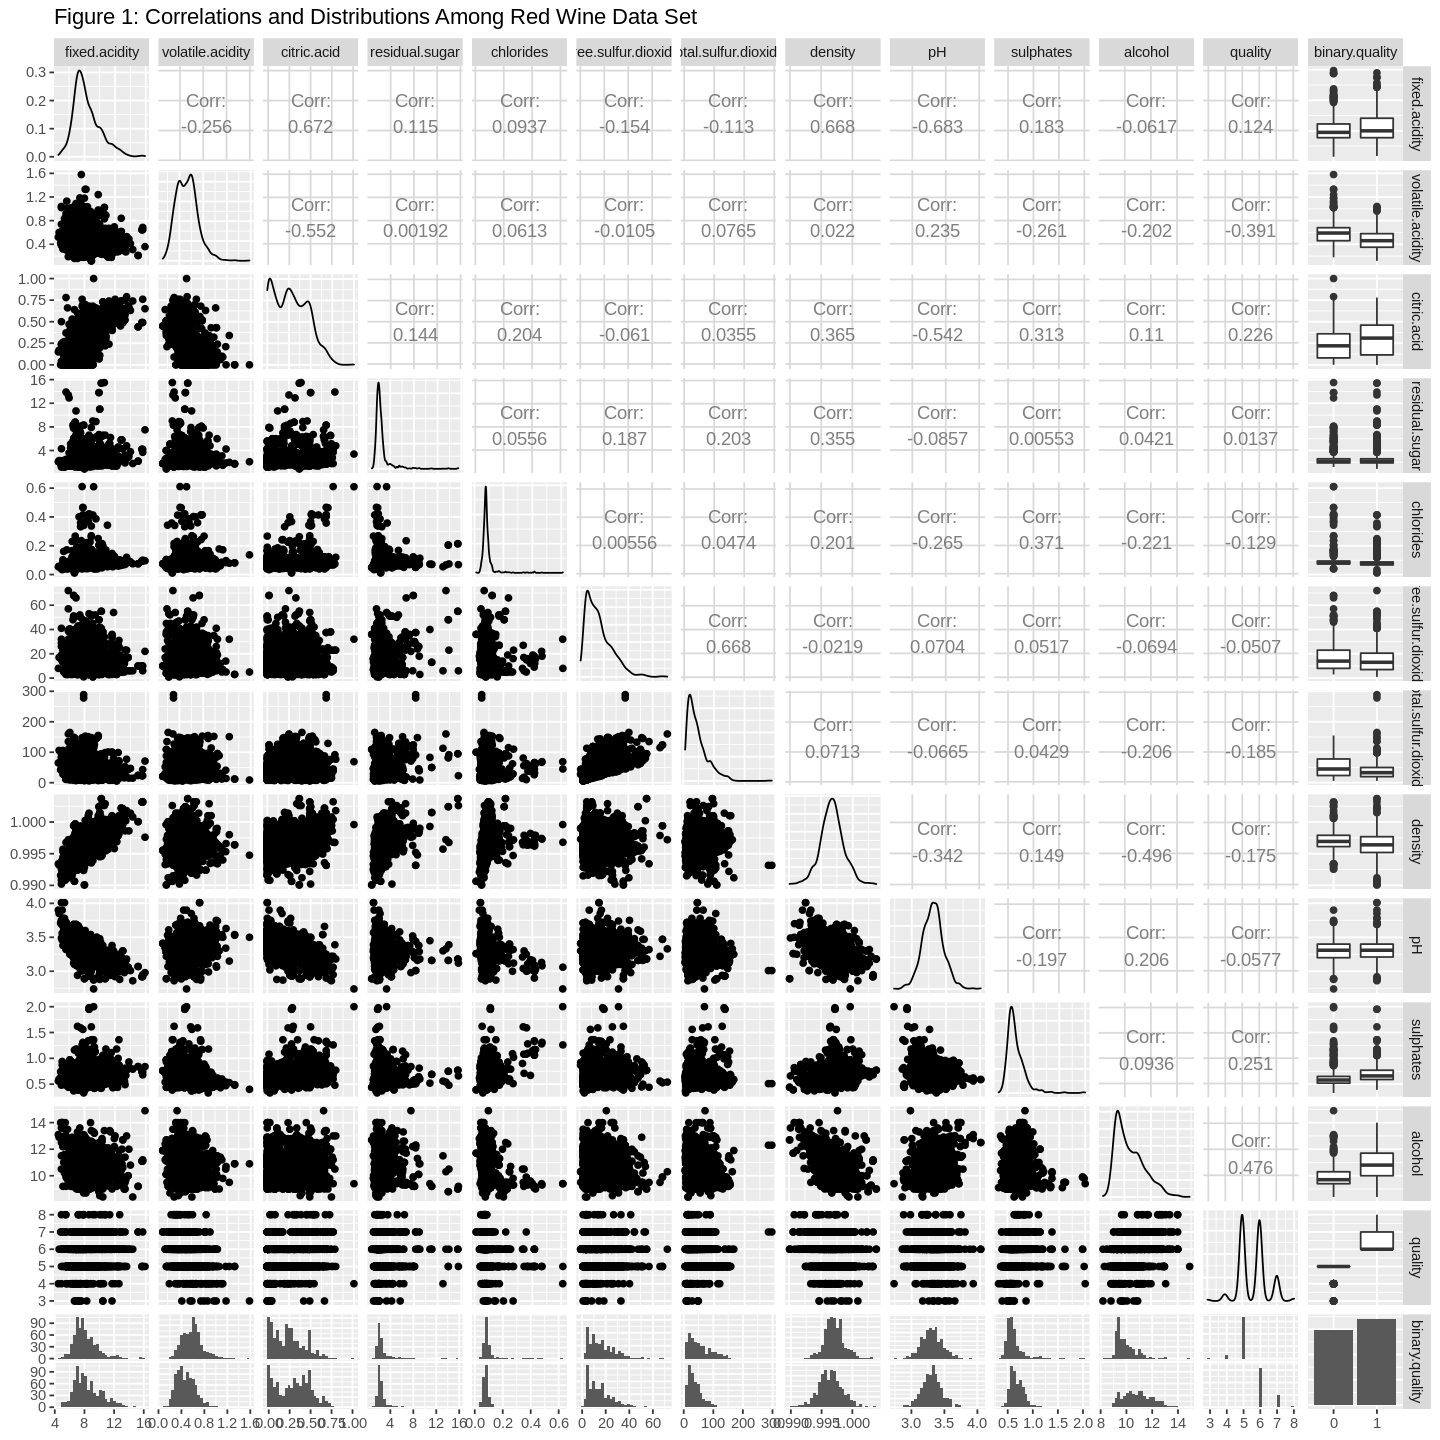

In [102]:
# Red wine plot and Pearson correlations
rw_plot <- ggpairs(rw_bin) + labs(title = "Figure 1: Correlations and Distributions Among Red Wine Data Set")

rw_corr <- rw_bin_non_fct %>%
    cor() %>% # cor() returns a vector, here we convert it to a data frame so we can use it
    as.data.frame() %>% 
    select(binary.quality) %>%
    arrange(desc(abs(binary.quality))) %>%
    tail(-2)

rw_plot
rw_corr

We now perform the identical operation but now on the white wine dataset.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



,binary.quality
,<dbl>
alcohol,0.3832799652
density,-0.2686955919
volatile.acidity,-0.2254399878
chlorides,-0.1839389663
total.sulfur.dioxide,-0.1709240272
residual.sugar,-0.0927563974
fixed.acidity,-0.0897490679
pH,0.0836872787
sulphates,0.0518577127


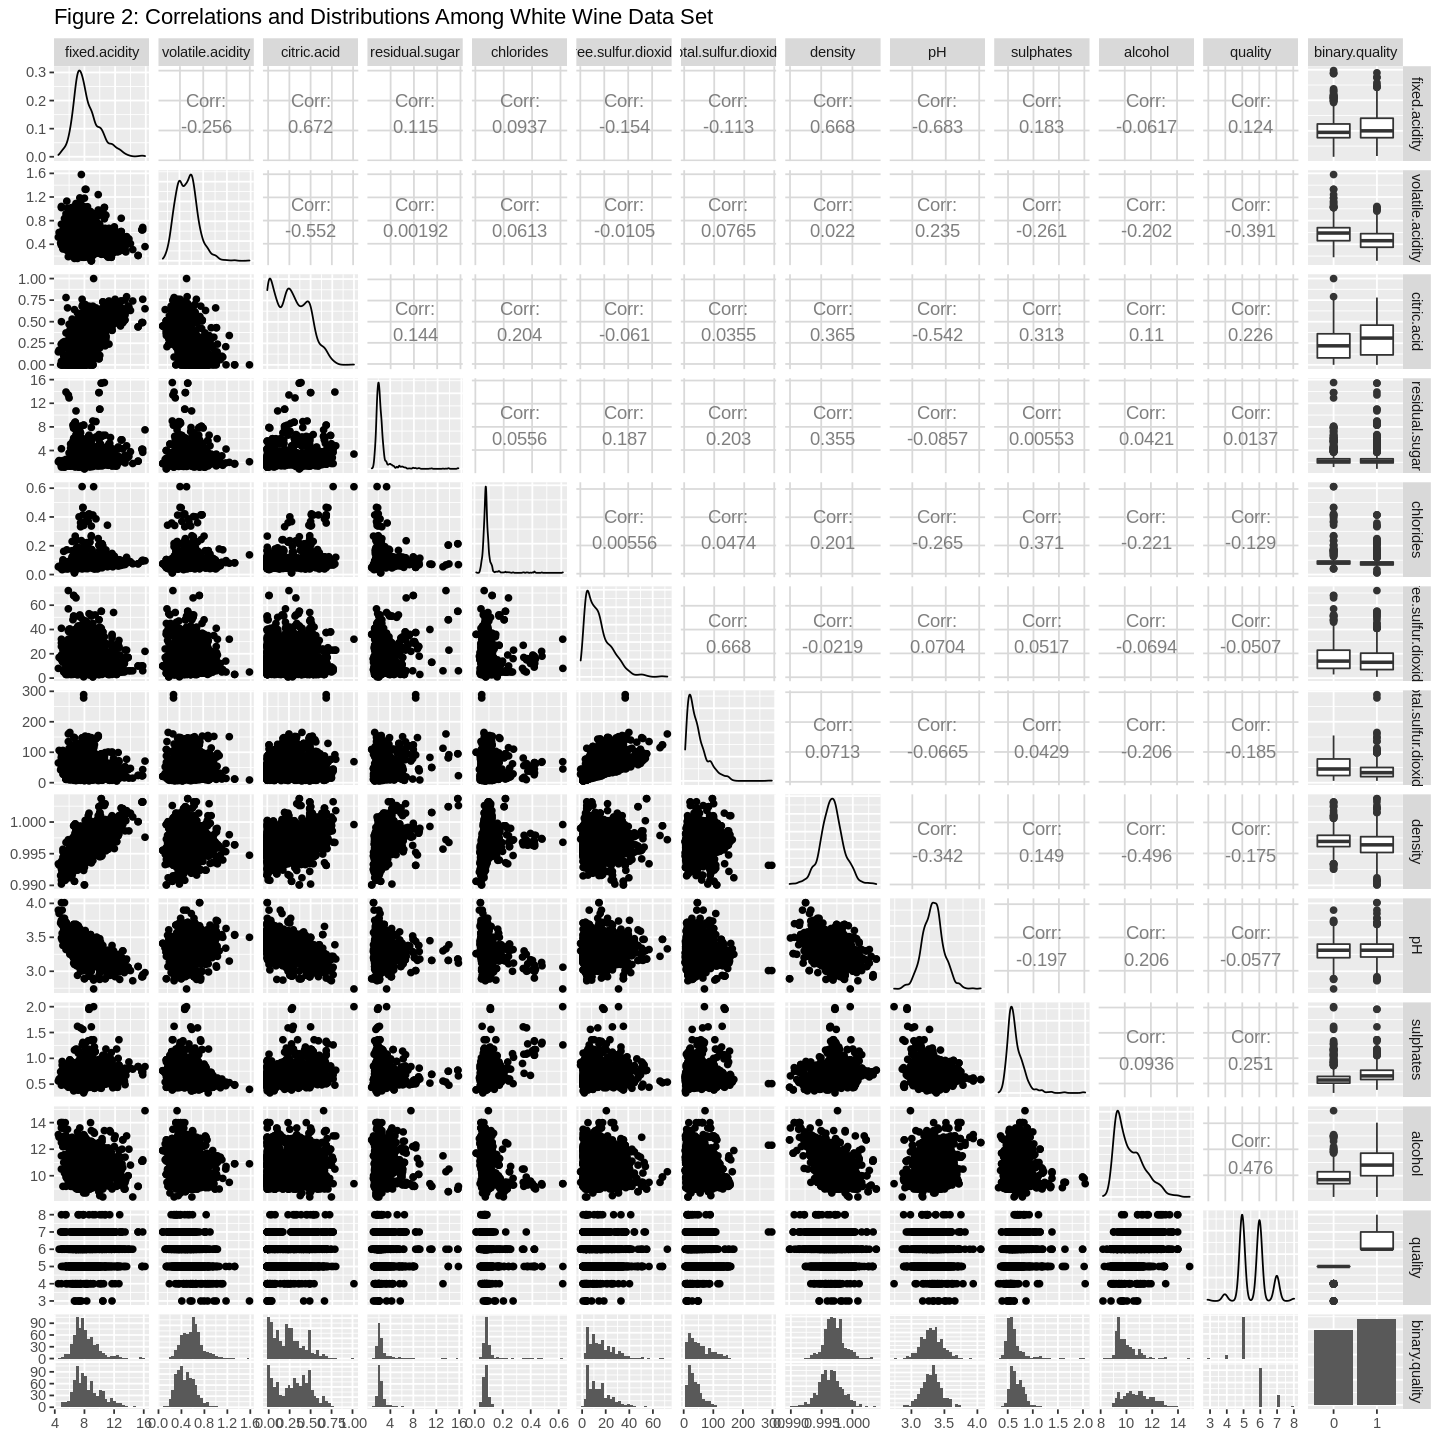

In [103]:
# White wine plot and Pearson correlations
ww_plot <- ggpairs(rw_bin)  + labs(title = "Figure 2: Correlations and Distributions Among White Wine Data Set")

ww_corr <- ww_bin_non_fct %>%
    cor() %>%
    as.data.frame() %>%
    select(binary.quality) %>%
    arrange(desc(abs(binary.quality))) %>%
    tail(-2)

ww_plot
ww_corr

Intuitively, it seems the quality of a red wine is more dependent on its physicochemical composition. We combine the tables below to confirm our intuition. We use merge() to join the data frames by their respective variables, then rename the columns to avoid using the automatically given names, and finally add a fourth variable that shows which correlation is larger between the two wines and their respective binary.quality variable.

In [7]:
total_corr <- merge(ww_corr, rw_corr, by = 'row.names', all = TRUE) %>%
    rename("variables" = Row.names, "white.wine" = binary.quality.x, "red.wine" = binary.quality.y) %>%
    mutate("stronger.correl" = if_else(white.wine > red.wine, "white", "red"))

total_corr

variables,white.wine,red.wine,stronger.correl
<I<chr>>,<dbl>,<dbl>,<chr>
alcohol,0.3832799652,0.434751205,red
chlorides,-0.1839389663,-0.109493996,red
citric.acid,-0.0007004692,0.159129408,red
density,-0.2686955919,-0.159109969,red
fixed.acidity,-0.0897490679,0.095093490,red
free.sulfur.dioxide,-0.0012781194,-0.061756744,white
pH,0.0836872787,-0.003263984,white
residual.sugar,-0.0927563974,-0.002160450,red
sulphates,0.0518577127,0.218071663,red


Confirming our intuition, the quality of a red wine, all else equal, is generally more dependent on its physicochemical composition. Of the 10 variables, red wines have stronger correlations for 6.

Therefore, to conduct a fruitful analysis, we will hereinafter use the red wine dataset for all analysis. We now visualize the density distributions of the five strongest red wine correlations. We fill the density distribution by the target variable and set alpha at 0.4 to visualize the overlap between the classes. We also ensure to use labs() to set proper x-axis, y-axis, legend, and title descriptions.

variables,red.wine
<I<chr>>,<dbl>
alcohol,0.434751205
volatile.acidity,-0.321440854
total.sulfur.dioxide,-0.231962976
sulphates,0.218071663
citric.acid,0.159129408
density,-0.159109969
chlorides,-0.109493996
fixed.acidity,0.095093490
free.sulfur.dioxide,-0.061756744


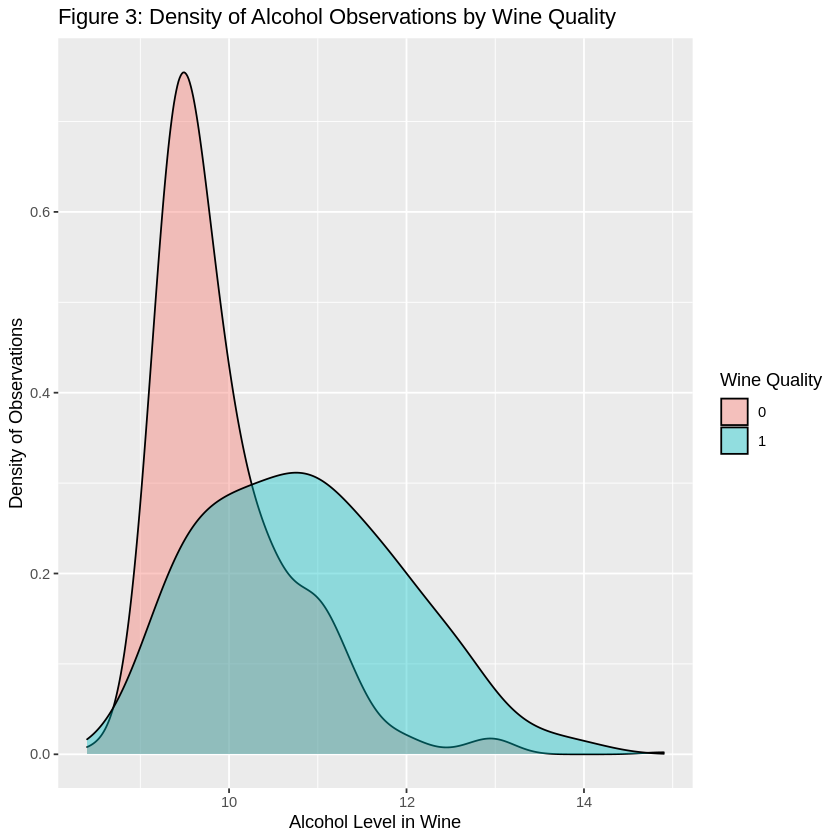

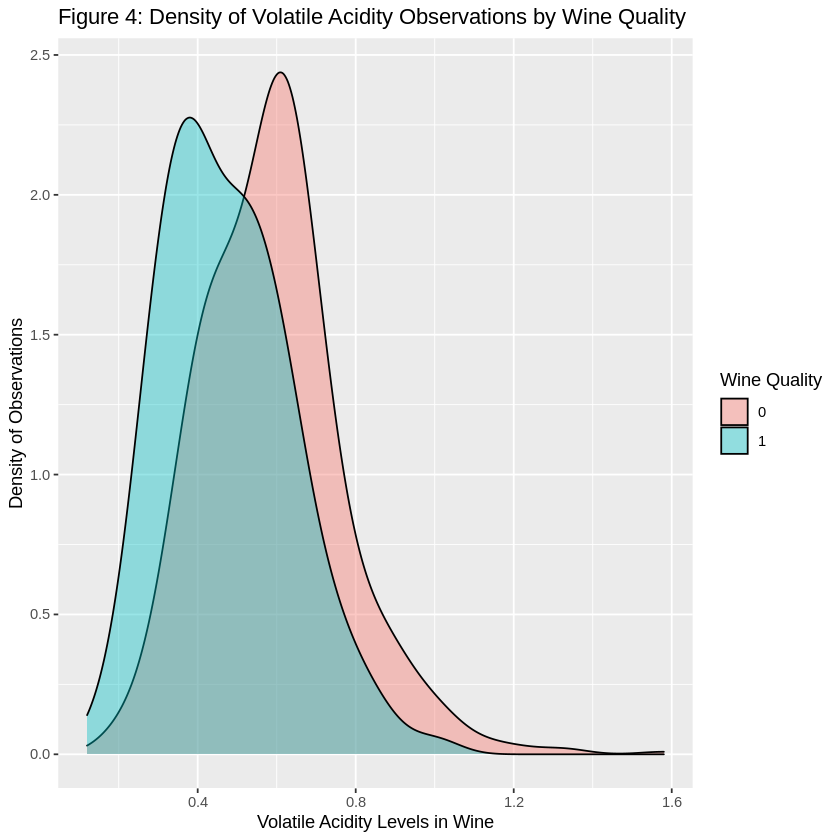

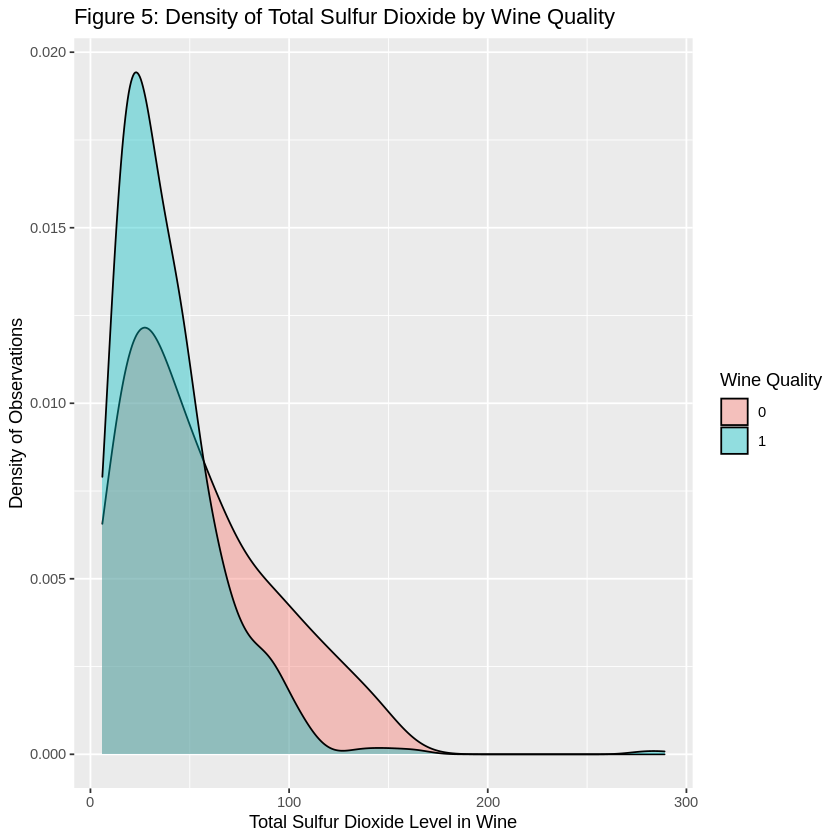

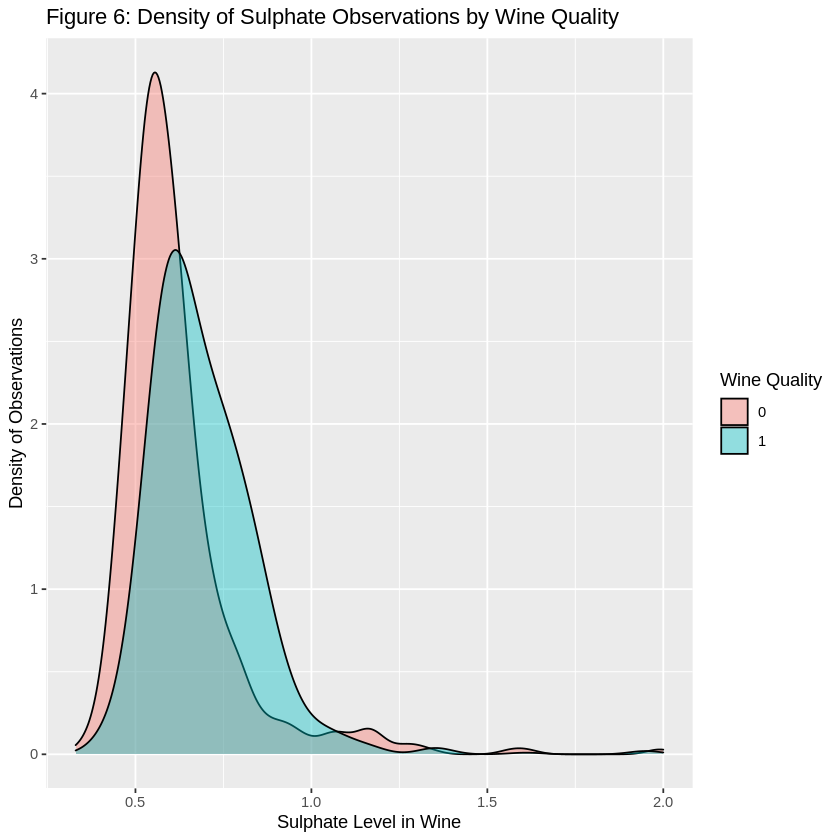

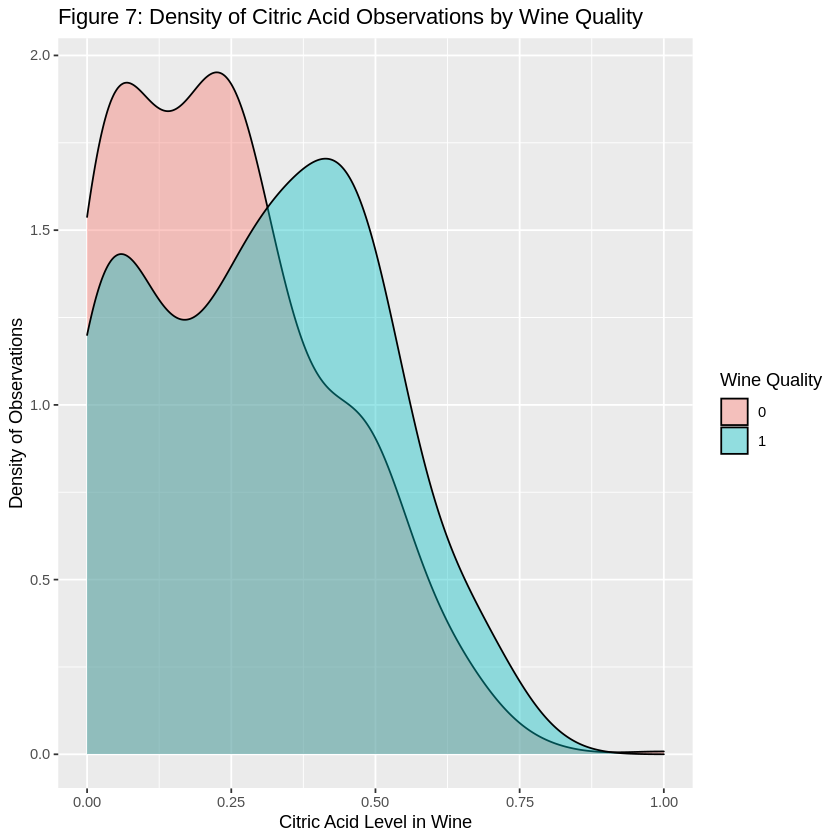

In [104]:
options(repr.plot.height = 7, repr.plot.width = 7)

# Ordering the strongest red wine correlations
rw_strongest <- total_corr %>%
    select(variables, red.wine) %>%
    arrange(desc(abs(red.wine)))

rw_strongest
# Alcohol density plot
alcohol_dens <- rw_bin %>%
    ggplot(aes(x = alcohol, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Alcohol Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Figure 3: Density of Alcohol Observations by Wine Quality")

# Volatile acidity density plot
volatile_acidity_dens <- rw_bin %>%
    ggplot(aes(x = volatile.acidity, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Volatile Acidity Levels in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Figure 4: Density of Volatile Acidity Observations by Wine Quality")

# Total sulfur dixoide plot
total_sulfur_dioxide_dens <- rw_bin %>%
    ggplot(aes(x = total.sulfur.dioxide, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Total Sulfur Dioxide Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Figure 5: Density of Total Sulfur Dioxide by Wine Quality")

# Sulphates
sulphates_dens <- rw_bin %>%
    ggplot(aes(x = sulphates, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Sulphate Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Figure 6: Density of Sulphate Observations by Wine Quality")

# Citric acid
citric_acid_dens <- rw_bin %>%
    ggplot(aes(x = citric.acid, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Citric Acid Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Figure 7: Density of Citric Acid Observations by Wine Quality")

alcohol_dens
volatile_acidity_dens
total_sulfur_dioxide_dens
sulphates_dens
citric_acid_dens

As exhibited in the above plots, alcohol level has the highest positive correlation to the quality of a red wine. The following plots also show moderately significant correlations, so we must decide which to use as to obtain the highest accuracy. We decide to only evaluate these five because of computational limitations and that their inclusion in the model would likely yield little benefit due to their near-zero correlation to the target variable.  

In [98]:
options(repr.plot.width = 12, repr.plot.height = 12)
set.seed(4862)

We first split into a testing and training dataset with 75-25 balance and then downsample the majority class to the minority class size, such that size of both training subsets are equal. The downsample process is completed by taking a random sample of the majority class equal to the size of the minority class. Once we have two subsets of the training dataset that are equal to eachother, we vertically bind them using rbind(). This causes the merged dataset to me ordered in ascending order, from 0 to 1. Future functions assume the passed dataset is randomized, so we shuffle the newly merged dataset by taking a random sample of itself, where the size of the random sample is equivalent to its current size.

We then finally use binary histograms to plot the overall data set, the training data set, and the testing data set. This shows that we have achieved the objective of balancing the training dataset while leaving the testing dataset unbalanced as it initially was.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


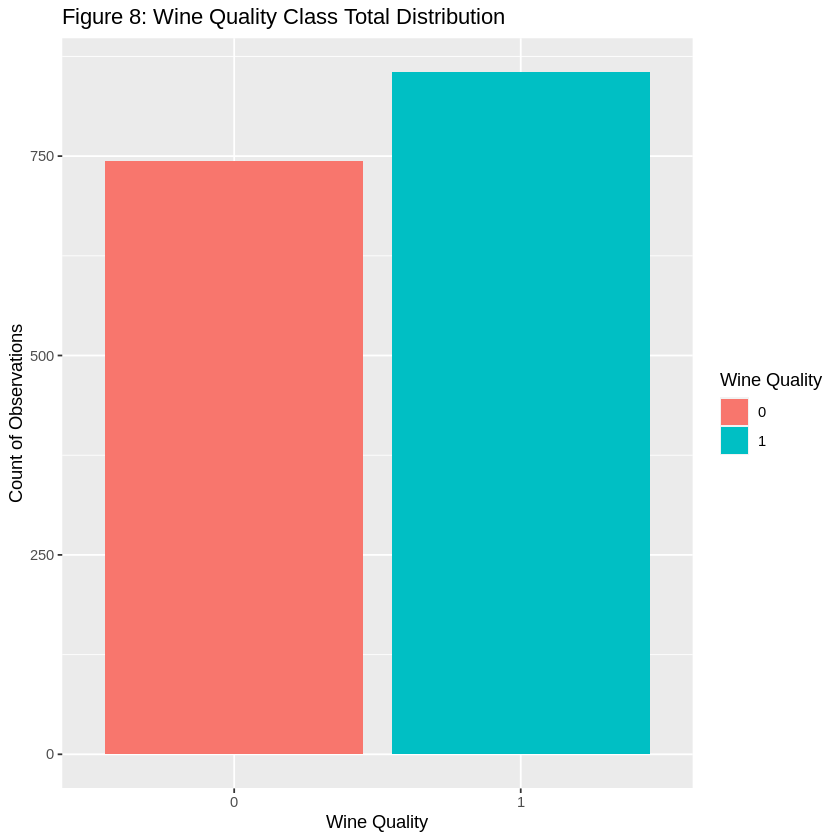

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


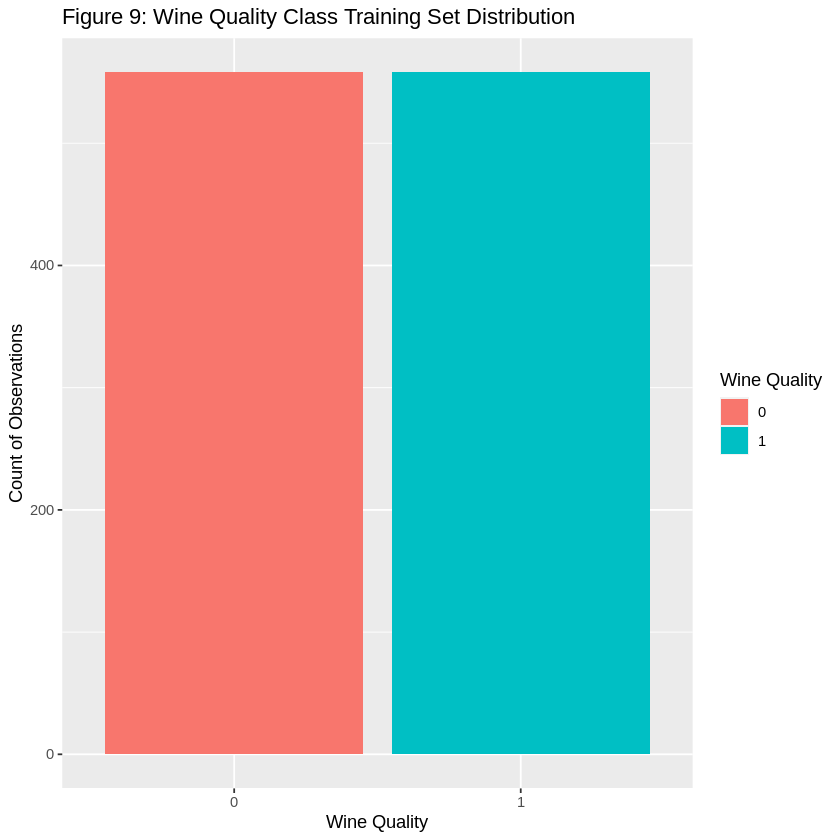

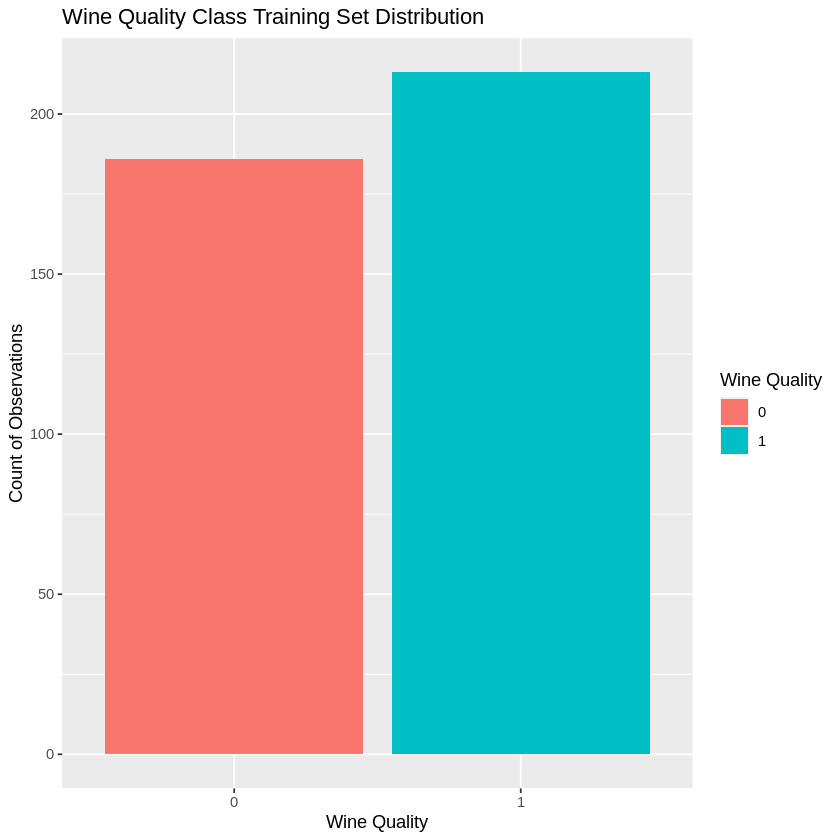

In [105]:
# Printing a binary histogram to demonstrate unbalanced overall data set
rw_bin_plot <- rw_bin %>%
    ggplot(aes(x = binary.quality, fill = binary.quality)) + 
    geom_histogram(binwidth = 0.5, stat = "count") +
    labs(x = "Wine Quality", y = "Count of Observations", fill = "Wine Quality", title = "Figure 8: Wine Quality Class Total Distribution")

rw_bin_plot

# Splitting into testing and training
rw_split <- initial_split(rw_bin, prop = 0.75, strata = binary.quality)
rw_train <- training(rw_split)
rw_test <- testing(rw_split)
# A 75-25 split means train data frame size = 1200, test size = 399, for a total of 1599

# Calculating length of good and bad classes on the train set
rw_train_bad <- rw_train[which(rw_train$binary.quality == 0),]
rw_train_good <- rw_train[which(rw_train$binary.quality == 1),]

rw_train_bad_size <- length(rw_train_bad$binary.quality)
rw_train_good_size <- length(rw_train_good$binary.quality)

# Downsampling the majority class of the training set to the size of the minority class
rw_train_good <- sample_n(rw_train_good, rw_train_bad_size)

# Combining both bad (minority) and good (former majority) data frames into one data frame
rw_train_combined <- rbind(rw_train_bad, rw_train_good)
# rw_train_combined # Print this to see it is unshuffled

# Shuffling the data frame as it is ordered in ascending order
rw_train_combined_shuffled <- rw_train_combined[sample(nrow(rw_train_combined)),]
# rw_train_combined_shuffled # Print this to see it is now shuffled

# Renaming the dataset
rw_train <- rw_train_combined_shuffled

# Demonstrating that the new training data set is equally balanced
rw_train_plot <- rw_train %>%
    ggplot(aes(x = binary.quality, fill = binary.quality)) + 
    geom_histogram(binwidth = 0.5, stat = "count") +
    labs(x = "Wine Quality", y = "Count of Observations", fill = "Wine Quality", title = "Figure 9: Wine Quality Class Training Set Distribution")

rw_train_plot


# Demonstrating that the testing data set remains imbalanced
rw_train_plot <- rw_test %>%
    ggplot(aes(x = binary.quality, fill = binary.quality)) + 
    geom_histogram(binwidth = 0.5, stat = "count") +
    labs(x = "Wine Quality", y = "Count of Observations", fill = "Wine Quality", title = "Figure 10: Wine Quality Class Training Set Distribution")

rw_train_plot

Prior to finding the optimal K value, we start the process of deciding which variables to include in our model. As having too many variables can harm the model, we must carefully decide which are beneficial to the overall accuracy and which are not.

This process is called feature selection and we will be using the forward selection process (Eforymson, 1966). This process essentially entails adding variables and calculating the accuracy at each new added variable. Once we have this dataset, we can plot each number of variables and its corresponding accuracy to understand when adding more variables becomes harmful to the model.

In summary of this process, we progess in the typical flow for finding the optimal K values. Instead, we use a nested for-loop to iterate through the variable combinations and calculate their respective accuracies.

In [99]:
# Creating a subset with the five variables we can computationally work with
rw_train_subset <- rw_train %>%
    select(alcohol, volatile.acidity, total.sulfur.dioxide, sulphates, citric.acid, binary.quality)

# Taking the names of the variables
predictors <- colnames(rw_train_subset %>% select(-binary.quality))

# Creating an empty tibble to store the results of the forward selection process
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Creating the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# Creating a 5-fold cross-validation object
rw_vfold <- vfold_cv(rw_train_subset, v = 5, strata = binary.quality)

# Store the total number of predictors with the length() function
n_total <- length(predictors)
# these 5 are alcohol, Volatile acidity, Total sulfur dixoide, Sulphates, Citric acid as we found they had the highest relative Pearson correlation coefficients to the target variable

# Storing selected predictors
selected <- c()

# loop for the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(predictors)) {
        # create a string for this combination of predictors
        preds_new <- c(selected, predictors[[j]])
        model_string <- paste("binary.quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        rw_recipe <- recipe(as.formula(model_string), 
                                data = rw_train_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # Tuning the KNN classifier with these predictors, 
        # Collecting the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(rw_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = rw_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # Adding this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, predictors[[jstar]])
    predictors <- predictors[-jstar]
}
accuracies

The output of this process is a data frame containing the average prediction accuracy for each combination and size of predictors. We plot the returned data on a line graph where we put the number of predictors on the X-axis, and the corresponding average accuracy on the Y-axis.

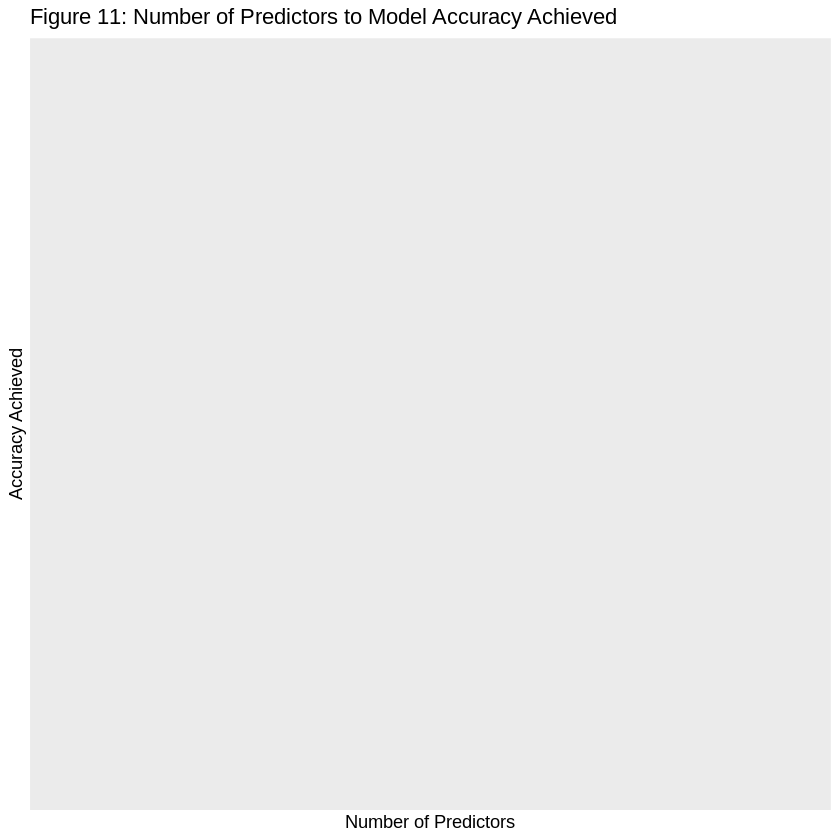

In [107]:
accuracies_plot <- accuracies %>%
    ggplot(aes(x = size, y = accuracy)) +
    geom_line() +
    labs(x = "Number of Predictors", y = "Accuracy Achieved", title = "Figure 11: Number of Predictors to Model Accuracy Achieved")

accuracies_plot

As illustrated above, the accuracy of the model diminishes as more variables are added. When using four variables, the accuracy of the model is optimized. We now implement these four predictors in a new model, and complete the typcial process for finding the optimal K value given the four predictor variables we now have.

The below process involves creating a recipe, standardizing and centering the recipe, creating a vfold object, setting up the KNN model, and finally combining this with the workflow() function. We then output accuracy estimates from the validation sets and summarize the findings using the accuracy metric. We make another line graph plotting the K-value to the average accuracy to further elucidate that the optimal K-value is 2.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7678732,5,0.009651895,Model01
4,accuracy,binary,0.7669643,5,0.009243521,Model02
5,accuracy,binary,0.7562420,5,0.007927096,Model03
6,accuracy,binary,0.7562420,5,0.007927096,Model04
7,accuracy,binary,0.7455277,5,0.004631598,Model05
9,accuracy,binary,0.7436856,5,0.005660829,Model06
10,accuracy,binary,0.7436856,5,0.005660829,Model07
12,accuracy,binary,0.7482223,5,0.002176182,Model08
13,accuracy,binary,0.7509250,5,0.007018957,Model09


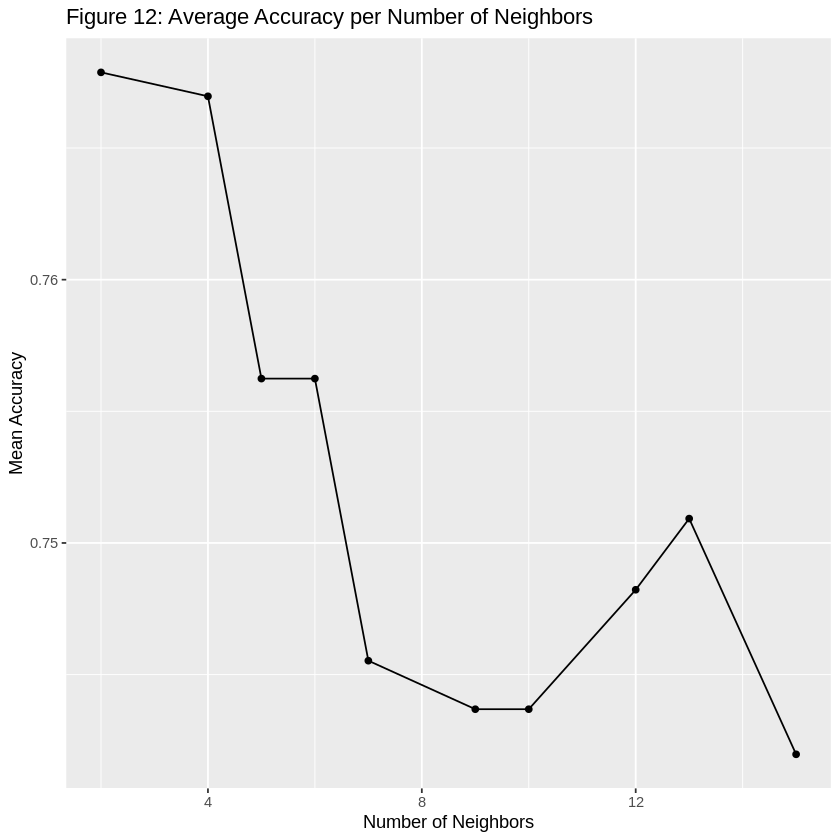

In [106]:
# Creating recipe
rw_recipe <- recipe(binary.quality ~ alcohol + volatile.acidity + sulphates + total.sulfur.dioxide, data = rw_train_subset) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Creating vfold
rw_vfold <- vfold_cv(rw_train_subset, v = 5, strata = binary.quality)

# Creating new nearest neighbors model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# Adding to workflow function and getting accuracy estimates
rw_fit <- workflow() %>%
    add_recipe(rw_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = rw_vfold, grid = 10)

# Gathering the fit metrics
rw_metrics <- collect_metrics(rw_fit)

# Collecting only the accuracy metrics
rw_metrics_accuracy <- rw_metrics %>%
                            filter(.metric == "accuracy")

# Plotting the neighbors to mean accuracy to elucidate the optimal K value
cross_val_plot <- rw_metrics_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Number of Neighbors", y = "Mean Accuracy", title = "Figure 12: Average Accuracy per Number of Neighbors")

rw_metrics_accuracy

cross_val_plot

In [82]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
            set_engine("kknn") %>%
            set_mode("classification")
                             
rw_fit <- workflow() %>%
    add_recipe(rw_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = rw_train_subset)

rw_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2535842
Best kernel: rectangular
Best k: 2

Knowing the optimal K value (2) and the optimal variable combination, we finally use the predict() function to make predictions on the untouched test-set. We collect the appropriate accuracy metrics using metrics() and filter(), and create a confusion matrix with conf_mat(). 

In [87]:
# Making predictions, then binding to one data frame
rw_predictions <- predict(rw_fit, rw_test) %>%
    bind_cols(rw_test)

# Filtering to only get the accuracy metric
rw_metrics <- rw_predictions %>%
    metrics(truth = binary.quality, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

# Creating a confusion matrix
rw_conf_mat <- rw_predictions %>% 
      conf_mat(truth = binary.quality, estimate = .pred_class)

rw_metrics
rw_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7318296


          Truth
Prediction   0   1
         0 141  62
         1  45 151

Finally, we find our optimized model returns a respectablle 73.2% accuracy.

<b>DISCUSSION</b>

First, we decided to use the red wine dataset because it has a stronger correlation between the predictors and target variable than the white wine dataset. We decide to only evaluate these five because of computational limitations and also due to the fact that their inclusion in the model would likely yield little benefit because of their near-zero correlation to the target variable. With this concern in mind, we performed a correlation test to find the strongest 5 variables. Out of these 5 strongest variables, we found the best combination of predictors through feature selection, which are alcohol, volatile acidity, sulphates and total sulfur dioxide. This gives an accuracy of 0.7840573. Then, we built a recipe using the above 4 variables. We decided to use the k-nearest neighbors classification algorithm to build a model for prediction. First, we performed a 5-fold validation to pick the best value of k. We found that the model is optimized when k = 2. We fitted the model to the training set, and tested it on the testing set. Our final model gives us an accuracy of 73%.

An accuracy of 73% is good enough for our model to be effective. Our model can correctly predict whether the wine has a good or bad quality at around 7 out of 10 times, and answers the question of if we can classify the quality of wine based on physicochemical properties. If the alcohol, volatile acidity, sulphates and total sulfur dioxide in a sample of wine are known in advance, our model can help the wineries to predict whether a particular wine is above or below the average wine quality.

Interest in wine has increased over the years and as a result, the wine industry has grown exceedingly. The extrinsic classification of wine oftentimes is not satisfactory when considering practices such as quality certification. Our findings are important in order to create an objective framework that can assist with determining quality. It can also help viticulturists understand the levels of physicochemical properties that are required to produce a better product, which will then lead to positive impacts within the wine consumer market and the broader industry. 
 
In the project, we used binary classification to put the new observations into two groups according to their physicochemical statistics. Instead, we can also try to regard the quality as a continuous variable. In this way, “regression” can be used to find out a double indicating the quality as a result. Besides, we used forward selection here to help choose suitable numbers of variables that best fit in the following binary classification. It is also worthy of research to figure out the differences of variable choice as well as final results if we change the process of feature selection.


<b>REFERENCES</b>

Cortez, Paulo, et al. “Modeling Wine Preferences by Data Mining from Physicochemical Properties.” Decision Support Systems, vol. 47, no. 4, 2009, pp. 547–553., https://doi.org/10.1016/j.dss.2009.05.016. 
Jackson, Ronald S. “Nature and Origins of Wine Quality.” Wine Tasting, 2017, pp. 337–370., https://doi.org/10.1016/b978-0-12-801813-2.00008-2. 

Eforymson, M. 1966. “Stepwise Regression—a Backward and Forward Look.” In Eastern Regional Meetings of the Institute of Mathematical Statistics.

Attar, Abdolrahman, et al. “A Survey of Image Spamming and Filtering Techniques.” Artificial Intelligence Review, vol. 40, no. 1, 2011, pp. 71–105., https://doi.org/10.1007/s10462-011-9280-4.  
Dina, Ayesha S., and D. Manivannan. “Intrusion Detection Based on Machine Learning Techniques in Computer Networks.” Internet of Things, vol. 16, 2021, p. 100462., https://doi.org/10.1016/j.iot.2021.100462. 

Galbusera, Fabio, et al. “Artificial Intelligence and Machine Learning in Spine Research.” JOR SPINE, vol. 2, no. 1, 2019, https://doi.org/10.1002/jsp2.1044. 


Thanks for reading!